In [ ]:
import numpy as np
import matplotlib.pylab as plt
from numpy import math
from scipy.optimize import curve_fit
import seaborn as sns
from scipy import stats
from scipy.stats import *
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize
!pip install emcee
!pip install corner
import emcee
import seaborn as sns
import corner
import pymc3 as pm

     |████████████████████████████████| 51kB 2.7MB/s 


# Implementación del modelo a los datos de .....

Los datos optenidos de https://loco.lab.asu.edu/edges/edges-data-release/, los cuales contienen la siguiente información **Frequency [MHz], Weight, a: Tsky [K], b: Tres1 [K], c: Tres2 [K], d: Tmodel [K], e: T21 [K]**

Donde la frecuencia y el peso son nuestros y a,b,c,d,e son nuestros parametros 

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving figure1_plotdata.csv to figure1_plotdata.csv
Saving Howell1.txt to Howell1.txt


In [ ]:
Dat=np.loadtxt('figure1_plotdata.csv',delimiter=',',skiprows=1)
Names=np.array(['Frequency [MHz]', 'Weight', 'a: Tsky [K]', 'b: Tres1 [K]', 'c: Tres2 [K]','d: Tmodel [K]', 'e: T21 [K]'
])

**Griaficas**

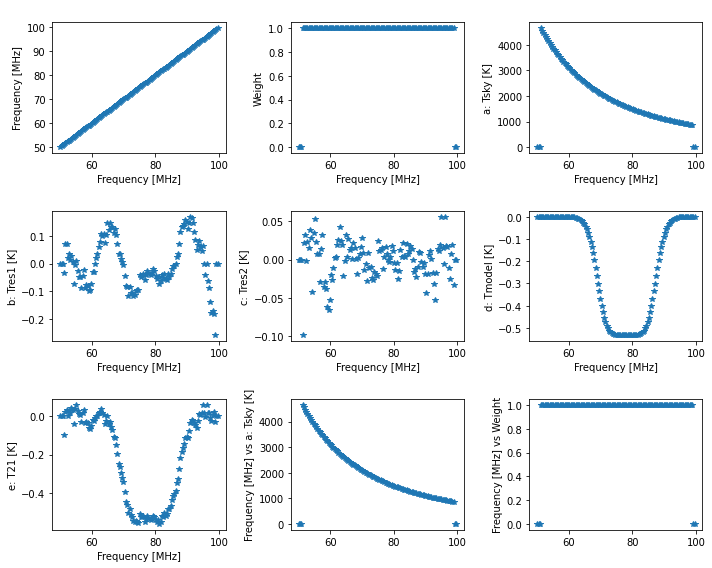

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(10, 8))
for i, ax in enumerate(axes.flat, start=0):
    if i >6:
      ax.plot(Dat[:,0],Dat[:,9-i],'*',label=Names[9-i])
      ax.set_ylabel(Names[0] +' vs '+Names[9-i])
    else:
      ax.plot(Dat[:,0],Dat[:,i],'*',label=Names[i])
      ax.set_title("  ")
      ax.set_xlabel(Names[0])
      ax.set_ylabel(Names[i])
      #ax.legend()
fig.tight_layout()

plt.show()

## Modelo

Los datos para nuestro modelo son frecuenciua vs temperatura sky.
 El modelo consiste en obtener $T_{sky}$ como la suma de $T_F$ (-.--------)y $T_{21}$ (Temperatura relacionada a la trancicion de 21 cm) $T_{sky}=T_F(\nu)+T_{21}(\nu)$
 
$T_F( \nu)$ esta modelada por la siguiente ecuación 

$$T_F(\nu)=a_o\left(\frac{\nu}{\nu_c}\right)^{-2.5}+a_1\left(\frac{\nu}{\nu_c}\right)^{-2.5}\log\left(\frac{\nu}{\nu_c}\right)+a_2\left(\frac{\nu}{\nu_c}\right)^{-2.5}\left[\log\left(\frac{\nu}{\nu_c}\right)\right]^2+a_3\left(\frac{\nu}{\nu_c}\right)^{-4.5}+a_4\left(\frac{\nu}{\nu_c}\right)^{-2.0}+$$

donde $T_F ( ν )$ es la temperatura de brillo de la emisión de primer plano, $ν$ es lafrecuencia, $ν_c$ es la frecuencia central de la banda observada y los coeficientes $a_n$ se ajustan a los datos. La función anterior es una aproximación lineal, centrada en $ν_c$ ,
$T_{21}$ tiene la siguiente expresón 
$$T_{21}=-A\left[\frac{1-e^{\tau e^B}}{1-e^{-\tau}}\right]$$

Donde 
$$B=\frac{4(v-\nu_o)^2}{w^2}\log\left(-{1\over \tau }\log\left({{1+e^{-\tau}}\over 2}\right)\right)$$


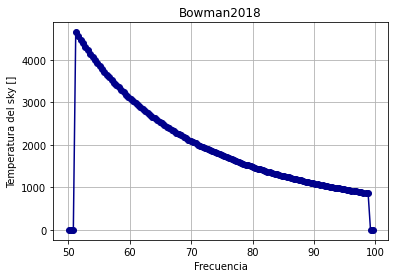

In [ ]:
plt.plot(Dat[:,0],Dat[:,2],color='darkblue',marker='o')
plt.title('Bowman2018')
plt.xlabel('Frecuencia')
plt.ylabel('Temperatura del sky []')
plt.grid()

# Ajuste lineal ejemplo (mínimos cuadrados curvefit)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


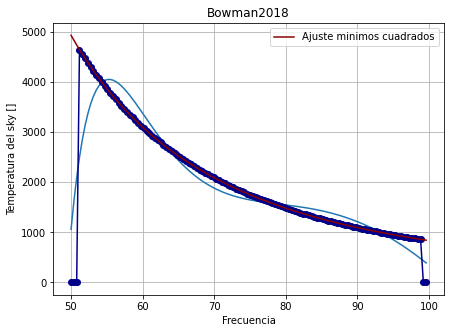

In [ ]:
def T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  vc=78.0
  Tf=a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  T21=-A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))
  return Tf+T21

popt, pcov = curve_fit(T_sky, Dat[:,0], Dat[:,2])
x_1,y_1=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0]
popt1, pcov1 = curve_fit(T_sky, x_1, y_1)
plt.figure(figsize=(7,5))
plt.plot(Dat[:,0],T_sky(Dat[:,0],*popt))
plt.plot(Dat[:,0],Dat[:,2],color='darkblue',marker='o')
plt.plot(Dat[:,0],T_sky(Dat[:,0],*popt1),color='darkred',label='Ajuste minimos cuadrados')
plt.title('Bowman2018')
plt.xlabel('Frecuencia')
plt.ylabel('Temperatura del sky []')
plt.grid()
plt.legend()

In [ ]:
popt

array([ 1.69467421e+07,  1.83509785e+07,  1.32644321e+07, -2.02155528e+05,
       -1.67430062e+07,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00])

Los resultados de los parametros usando este metodo, difieren mucho de los reportados en el texto deEdges.

# MLE ajuste

In [ ]:
plt.plot(x, T_sky(x,1560, 600,-1000,750,-100,600,78.2,21.0,7.0))

NameError: ignored

# Funciones de la Temperatura señal de 21 cm, de foreground, y de cielo.

In [ ]:
"""
Funciones de la temperatura 
Sky

"""
##################################0-
def T_f(v,a0,a1,a2,a3,a4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
def T_21(v,A,v0,w,tau):
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return-A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))

def T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf




La funcion Temperatura de cielo, contiene los parametros **(v,a0,a1,a2,a3,a4,A,v0,w,tau)** estos se van a determinar  maximizando la función de maxima probabilidad, 
El valor de la frecuancia central es determina de la siguiente manera,

In [ ]:
print('el valor de la frecuancia central vc es:' )
np.median(Dat[:,0]),Dat[:,0][Dat[:,6]<-0.4].mean()

el valor de la frecuancia central vc es:


(74.8168945, 78.3325195)

#Funciones de Maxima probalilidad


In [ ]:

"""
Función de Maxima Probabilidad

"""
#### Funcion de probabilidad

def log_likelihood(theta,x,y,sigma):
  v=x
  a0,a1,a2,a3,a4,A,v0,w,tau,log_f = theta
  sn2=sigma**2+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2*np.exp(2*log_f)
  return -0.5*sum((y-T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))**2/sn2+ np.log(2*np.pi*sn2))
# El logaritmo se debe que la función recibe el logaritmo de 


#### Funcion de probabilidad

def log_likelihood(theta,x,y,sigma):
  v=x
  a0,a1,a2,a3,a4,A,v0,w,tau = theta
  sn2=sigma**2#+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))**2/sn2  + np.log(2*np.pi*sn2))


"""función prior"""
# theta es un arreglo con los valores de las contantes del modelo 
def log_p (theta):
  a0,a1,a2,a3,a4,A,v0,w,tau = theta
  if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 300.0 < A < 150.0 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 4.5 <tau< 13.0:
      return 0.0
  return -np.inf

# log probabilidad

"""posterior """
def log_probability(theta, x, y, yerr):
    lp = log_p(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr) # Se suman por que estamos en elas funciones logaritmicas 

In [ ]:
#Parametros 
names=np.array(['a0','a1','a2','a3','a4','A','v0','w','tau'])
a0,a1,a2,a3,a4,A,v0,w,tau= 1570, 700,-1300,750,-175,460,78.3,20.75,6.0              # intersección con el eje y
f=Dat[:,2].std() # distribucon estandar de las Temperatura

#Variables
 # ""   ""   ""    ""    ""     ""   que tienen una distribución normal 
x,y=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0] # Variables
yerr=1.0+0*x# np.random.random_sample(len(x))  # Error 
N=len(x) #longitud del arreglo
 
x0=np.linspace(min(x),max(x),N) 


In [ ]:
nll=lambda *args: -log_likelihood(*args) # Construccion de la funcion lamda 

#Condiciones iniciales

In=np.array([a0,a1,a2,a3,a4,A,v0,w,tau]) + 0.1 * np.random.randn(9)
#Solución
Sol=minimize(nll,In,args=(x, y, yerr))
# Extrayendo los valores de los parametros arojados por MlE
popt = Sol.x
print('los valores de las constantes son\n ')
for i in range( len(names)):
  print( '    ',  names[i], '  es :  ',popt[i])


los valores de las constantes son
 
     a0   es :   1617.1835515530447
     a1   es :   -254.38428654863085
     a2   es :   115.58351632129836
     a3   es :   0.810095802388891
     a4   es :   -33.78505283624661
     A   es :   328.9529154418639
     v0   es :   23.396154266570505
     w   es :   -85.42930215579688
     tau   es :   -10.954694671622603


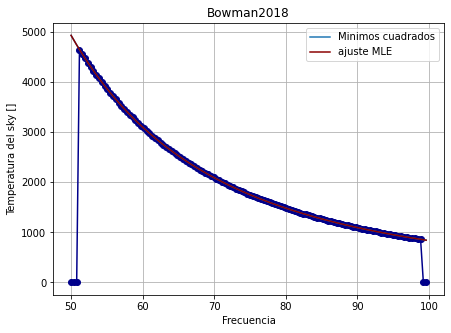

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(Dat[:,0],Dat[:,2],color='darkblue',marker='o')
plt.plot(Dat[:,0],T_sky(Dat[:,0],*popt1),label='Minimos cuadrados')
plt.plot(Dat[:,0],T_sky(Dat[:,0],*popt),color='darkred',label='ajuste MLE')
plt.title('Bowman2018')
plt.xlabel('Frecuencia')
plt.ylabel('Temperatura del sky []')
plt.legend()
plt.grid()

In [ ]:
pos = Sol.x + 1e-2 * np.random.randn(2500, 9)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 2500, progress=True);

100%|██████████| 2500/2500 [01:01<00:00, 40.55it/s]


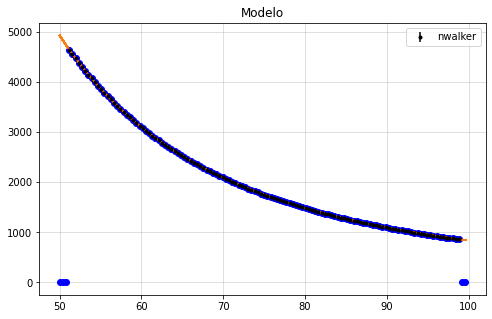

In [ ]:
params=sampler.get_chain(discard=9, thin=1000, flat=True)#parametros


plt.figure(figsize=(8,5))
plt.plot(Dat[:,0],Dat[:,2],'bo')
for i in range(len(params)):
  ms=params[0]
  ms=ms[0:9]
  plt.plot(Dat[:,0],T_sky(Dat[:,0],*params[i]), "C1", alpha=0.1)
plt.errorbar(x,y,yerr=yerr,fmt='.k',capsize=0,label='nwalker') #Grafica la muetras con su respectivo error
#plt.xlim(min(x),max(x))
plt.title('Modelo')
#plt.ylim(min(y),max(y))
plt.legend()
plt.grid(alpha=0.5)

In [ ]:
popt2=params.mean(axis=0)
popt2


array([ 1.61178235e+03, -2.60706470e+02,  1.15319295e+02,  1.12908241e+00,
       -2.85426363e+01,  3.47713664e+02,  2.30954123e+01, -8.42040130e+01,
       -1.05704769e+01])

##Grafico de esquina:

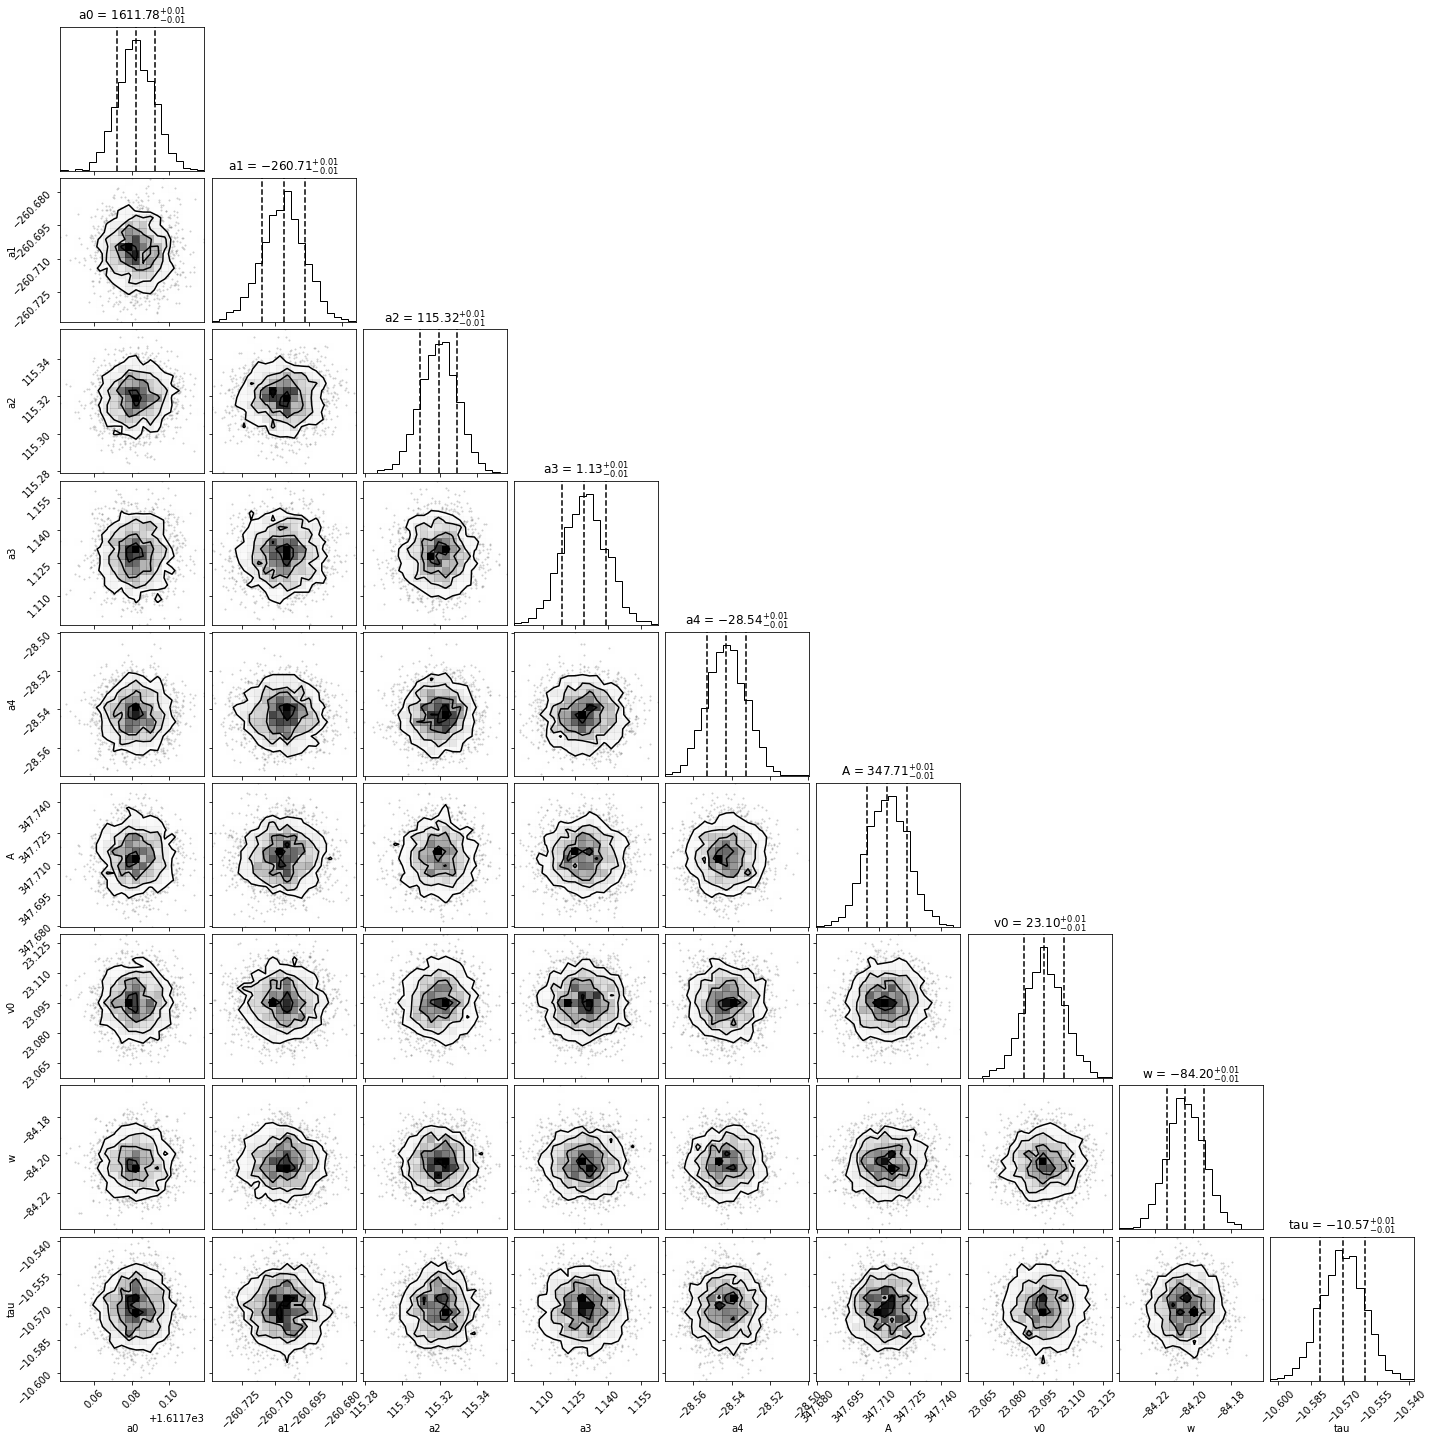

In [ ]:
corner.corner(params,labels=names,quantiles=[0.16, 0.5, 0.84],show_titles=True) 
plt.show()

#Modelo Pymcee

In [ ]:
ds=pd.read_csv('figure1_plotdata.csv',sep=',')
ds.head()
ds2=ds[ds.iloc[:,2]>1.0] 

In [ ]:
d1=ds2.iloc[:,0] # Valores de frecuencia
d2=ds2.iloc[:,2] # Valores de la temperatura

#v=d1.freq-d1.freq.mean()/d1.freq.std()
v=d1#.freq
vc=78.0


with pm.Model() as pred_model:
    vc=78.01
    a0=pm.Normal('a0',mu=1570,sd=60)
    a1=pm.Normal('a1',mu=700,sd=100)
    a2=pm.Normal('a2',mu=-1300,sd=100)
    a3=pm.Normal('a3',mu=750,sd=150)
    a4=pm.Normal('a4',mu=-175,sd=25)
#    TF=(a0*(v)**-2.5+a1*(v)**-2.5*np.log10(v)+a3*(v)**-4.5+a4*(v)**-2.0+a2*(v)**-2.5*np.log10(v)**2)
    A=pm.Normal('A',mu=460,sd=100)
    v0=pm.Normal('v0',mu=78.3,sd=0.1)
    w=pm.Normal('w',mu=20.75,sd=0.25)
    tau=pm.Normal('tau',mu=6.0,sd=1.5)
#    T21=-A*(1-np.e**(tau*np.e**(4*(v-v0)**2/w**2*(np.log10(-1/tau*np.log10((1+np.e**-tau)/2))))))/(1-np.e**-tau)
    B=((4*(v0-v)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
    mu=pm.Deterministic('mu',a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2  -  A*(1-(np.exp(-tau*np.exp(B))))/(1-(np.e**(-tau))))
#    mu=pm.Deterministic('mu',T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))
    sigma=pm.Uniform('sigma',lower=0,upper=50)
    Tsky=pm.Normal('Tsky',mu=mu,sd=sigma,observed=d2)
    trace_pred=pm.sample(1500,tune=1500)
filt1=np.array([np.logical_not('_interval__' in k) for k in trace_pred.varnames])
filt2=np.array([np.logical_not('mu' in k) for k in trace_pred.varnames])
vnames=np.array(trace_pred.varnames)[filt1&filt2] # arreglo con los nombres
trace_array_3=np.array([trace_pred[i] for i in vnames]).T

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [sigma, tau, w, v0, A, a4, a3, a2, a1, a0]
INFO:pymc3:NUTS: [sigma, tau, w, v0, A, a4, a3, a2, a1, a0]
100%|██████████| 3000/3000 [11:50<00:00,  4.22it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 261 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 261 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6444160010232631, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statist

In [ ]:
mean_pars=trace_array_3.mean(axis=0)
pars=mean_pars[0:9]
print('los valores de las constantes son\n ')
for i in range( len(names)):
  print( '    ',  names[i], '  es :  ',pars[i])


los valores de las constantes son
 
     a0   es :   1732.059885686002
     a1   es :   141.88402861307267
     a2   es :   -711.8863402346354
     a3   es :   37.89119683334429
     a4   es :   -185.55321833207054
     A   es :   2.5929624885565907
     v0   es :   78.61404182992683
     w   es :   21.302702329404948
     tau   es :   1.6439092962433293


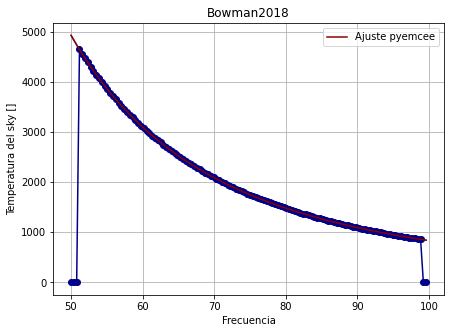

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(Dat[:,0],T_sky(Dat[:,0],*pars))
plt.plot(Dat[:,0],Dat[:,2],color='darkblue',marker='o')
plt.plot(Dat[:,0],T_sky(Dat[:,0],*pars),color='darkred',label='Ajuste pyemcee')
plt.title('Bowman2018')
plt.xlabel('Frecuencia')
plt.ylabel('Temperatura del sky []')
plt.grid()
plt.legend()

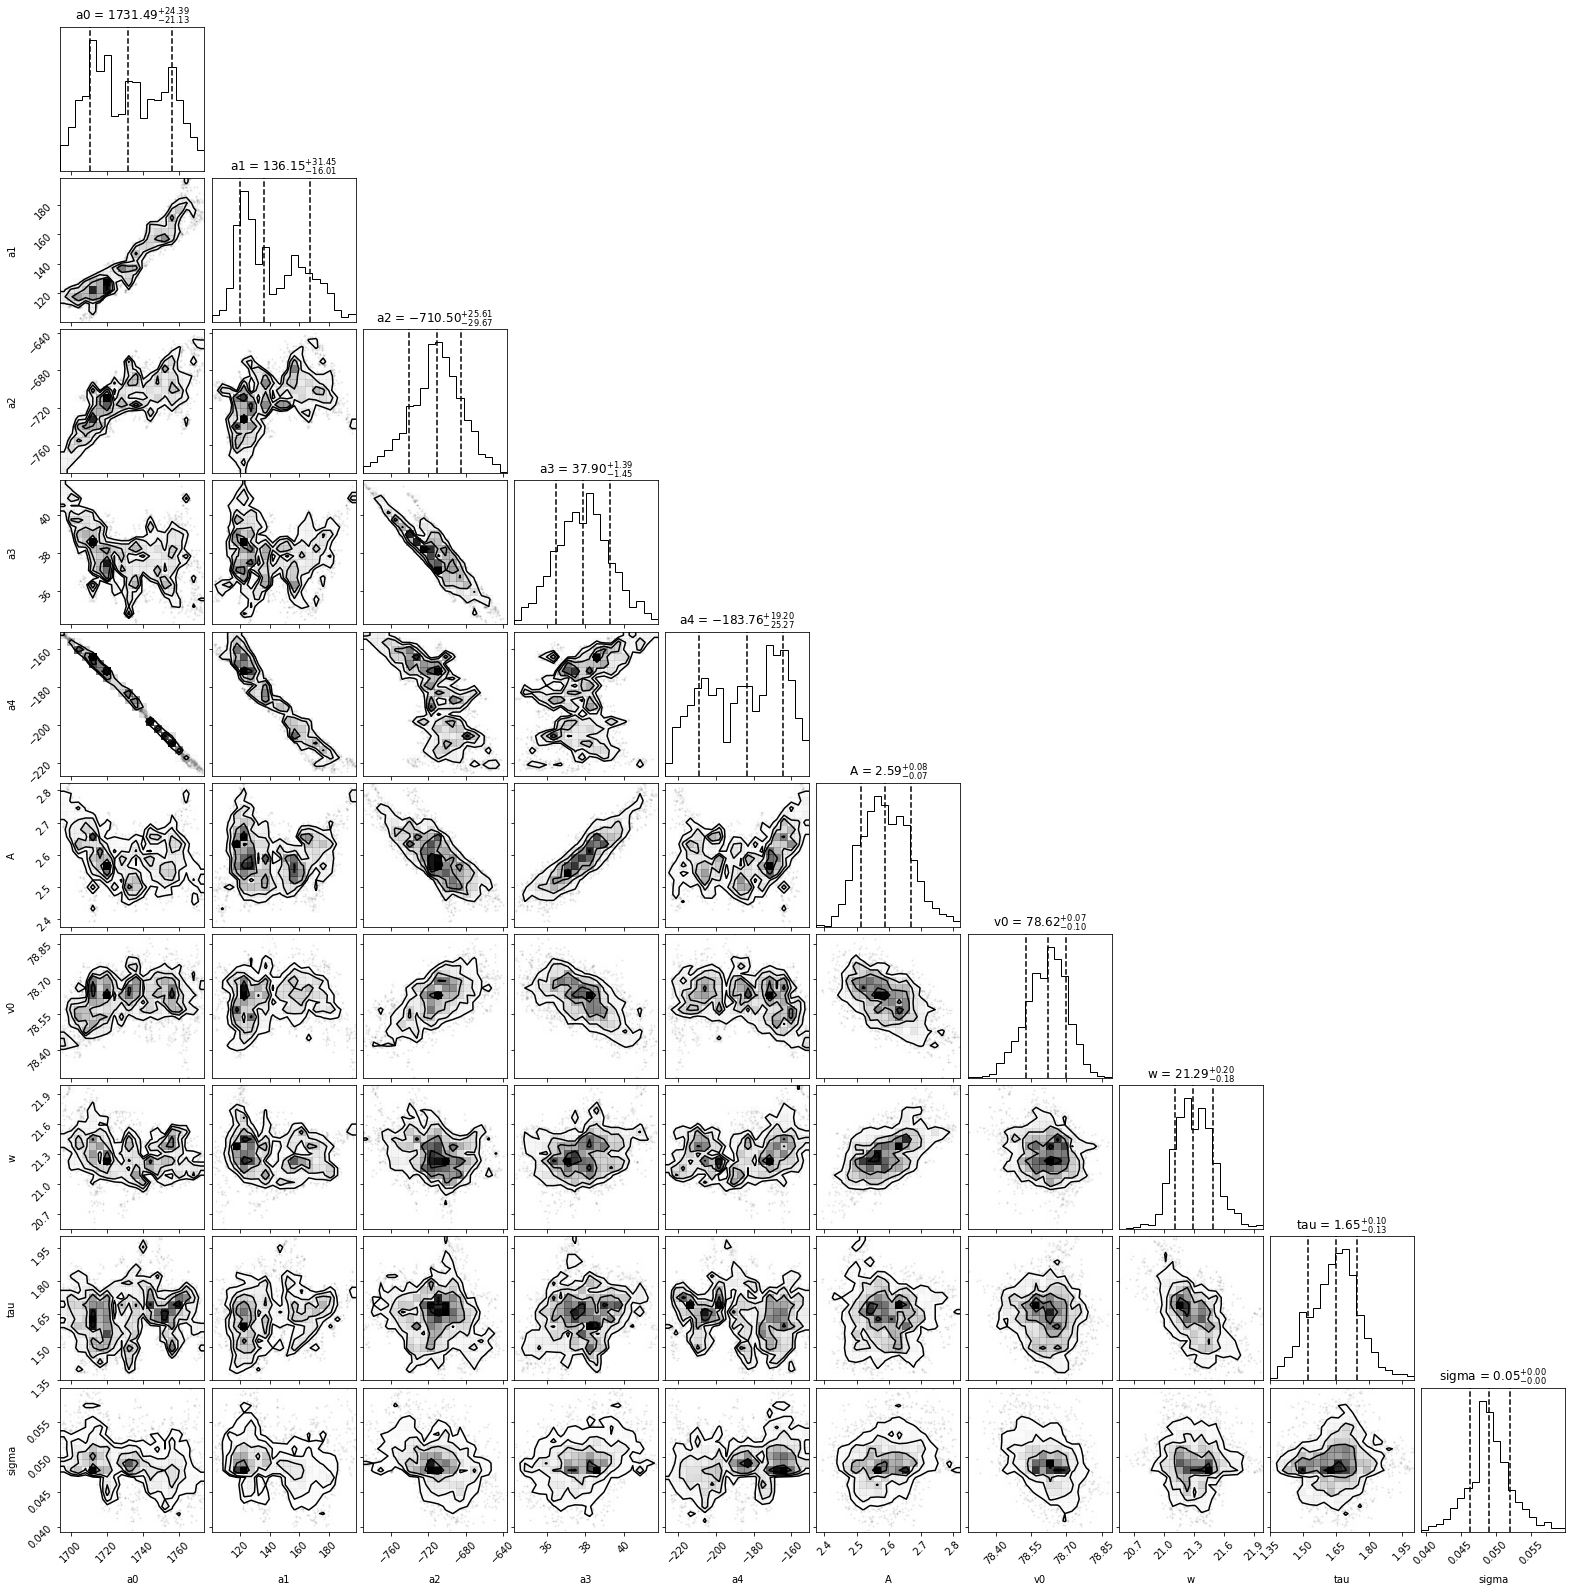

In [ ]:

corner.corner(trace_array_3,labels=vnames,quantiles=[0.16, 0.5, 0.84],show_titles=True) 
plt.show()

# Residuales

Graficas de Tf y t21

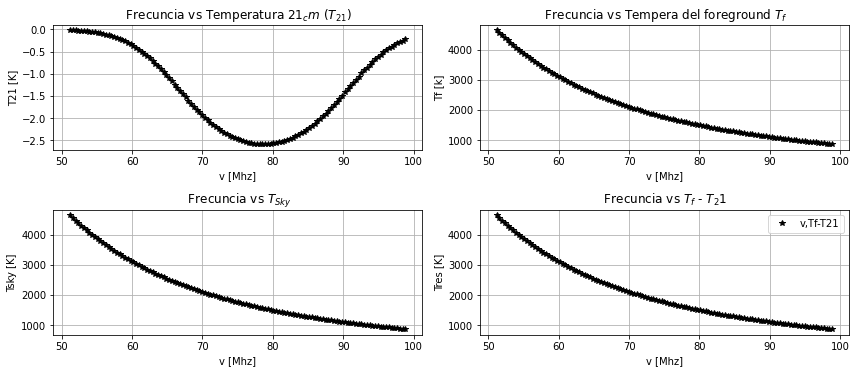

In [ ]:
a0,a1,a2,a3,a4,A,v0,w,tau=pars
plt.figure(figsize=(12,10))
plt.subplot(4,2,1)
plt.plot(v, T_21(v,A,v0,w,tau),'k*')
plt.title(' Frecuncia vs Temperatura $21_cm$ ($T_{21}$) ')
plt.xlabel('v [Mhz]')
plt.ylabel('T21 [K]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,2)
plt.plot(v,T_f(v,a0,a1,a2,a3,a4),'k*')
plt.title(' Frecuncia vs Tempera del foreground $T_f$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tf [k]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,3)
plt.plot(v,T_f(v,a0,a1,a2,a3,a4)+ T_21(v,A,v0,w,tau),'k*')
plt.title(r' Frecuncia vs $T_{Sky}$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tsky [K]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,4)
plt.plot(v,T_f(v,a0,a1,a2,a3,a4)- T_21(v,A,v0,w,tau),'k*',label='v,Tf-T21')
plt.title(' Frecuncia vs $T_f$ - $T_21$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tres [K]')
plt.legend()
plt.tight_layout()
plt.grid()

Mdelos de La Temperatura de señal de 21 cm y de Foreground

In [ ]:
Dat1=Dat[Dat[:,2]>0]
a0,a1,a2,a3,a4,A,v0,w,tau=popt
vc=np.median(v)
#Modelos
Tf_mod=T_f(Dat1[:,0],a0,a1,a2,a3,a4)
T21_mod=T_21(Dat1[:,0],A,v0,w,tau)
Tsky_mod=T_sky(Dat1[:,0],a0,a1,a2,a3,a4,A,v0,w,tau)
#Datos Tsky [K], b: Tres1 [K], c: Tres2 [K], d: Tmodel [K], e: T21 [K]
Tsky=Dat1[:,2]
Tes1=Dat1[:,3]
Tres2=Dat1[:,4]
T21=Dat1[:,6]

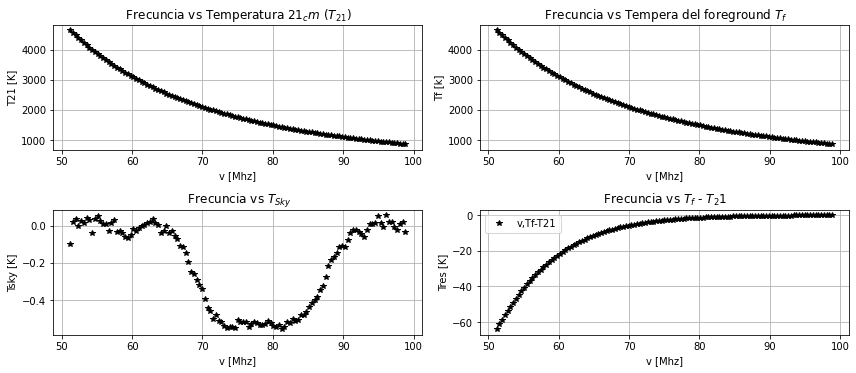

In [ ]:
#Comparación 


plt.figure(figsize=(12,10))
plt.subplot(4,2,1)
plt.plot(Dat1[:,0], Tsky,'k*')
plt.title(' Frecuncia vs Temperatura $21_cm$ ($T_{21}$) ')
plt.xlabel('v [Mhz]')
plt.ylabel('T21 [K]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,2)
plt.plot(Dat1[:,0],Tsky_mod,'k*')
plt.title(' Frecuncia vs Tempera del foreground $T_f$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tf [k]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,3)
plt.plot(Dat1[:,0],T21,'k*')
plt.title(r' Frecuncia vs $T_{Sky}$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tsky [K]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,4)
plt.plot(Dat1[:,0],T21_mod,'k*',label='v,Tf-T21')
plt.title(' Frecuncia vs $T_f$ - $T_21$ ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tres [K]')
plt.legend()
plt.tight_layout()
plt.grid()

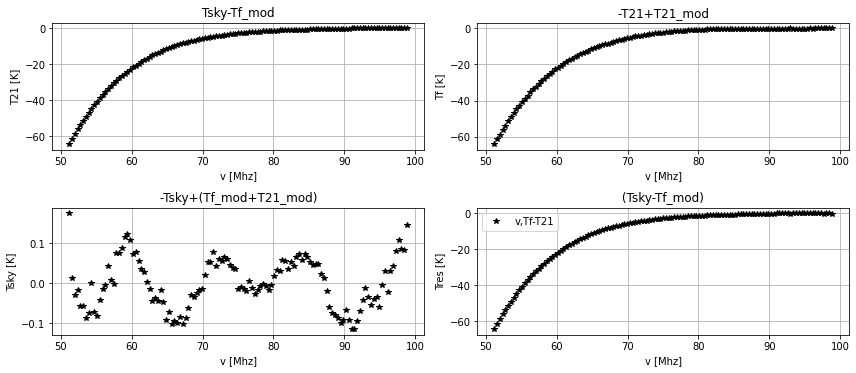

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(4,2,1)
plt.plot(Dat1[:,0], Tsky-Tf_mod,'k*')
plt.title(' Tsky-Tf_mod ')
plt.xlabel('v [Mhz]')
plt.ylabel('T21 [K]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,2)
plt.plot(Dat1[:,0],-T21+T21_mod,'k*')
plt.title(' -T21+T21_mod ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tf [k]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,3)
plt.plot(Dat1[:,0],-Tsky+(Tf_mod+T21_mod),'k*')
plt.title(r' -Tsky+(Tf_mod+T21_mod) ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tsky [K]')
plt.tight_layout()
plt.grid()
plt.subplot(4,2,4)
plt.plot(Dat1[:,0],(Tsky-Tf_mod),'k*',label='v,Tf-T21')
plt.title(' (Tsky-Tf_mod) ')
plt.xlabel('v [Mhz]')
plt.ylabel('Tres [K]')
plt.legend()
plt.tight_layout()
plt.grid()